In [8]:
from influxdb_client import InfluxDBClient, Point, WritePrecision
from influxdb_client.client.write_api import SYNCHRONOUS
import datetime
import numpy as np 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#config 
market = "SOL-PERP" 
horizon = "" #will be filled dyanamically // do not change 
trainingdate = datetime.date.strftime(datetime.date.today(), "%m_%d_%Y")


class InfluxFunctions():

    def __init__(self,token,org,bucket,url):
        self.token = token
        self.org = org
        self.bucket = bucket
        self.url = url
        self.client = InfluxDBClient(url=url, token=token, enable_gzip=True, org=org, timeout=None)
        self.write_api = self.client.write_api(write_options=SYNCHRONOUS)
        self.query_api = self.client.query_api()

        TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"
    def get_raw_data_exclude(self,perp_market):
        
        p = {"_bucket": self.bucket,
             "_start": datetime.timedelta(days=-10),
             "_stop": datetime.timedelta(seconds=-1),
             "_measurement": "funding-rates",
             "_market": perp_market,
             "_every": datetime.timedelta(days=1)
             }

        dataframe = self.query_api.query_data_frame('''
                        from(bucket: _bucket)
                  |> range(start: _start, stop: _stop)
                  |> filter(fn: (r) => r["_measurement"] == _measurement)
                  |> filter(fn: (r) => r["market"] == _market)
                  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")

                  |> drop(columns: ["_stop","_start"])
                  
                        ''', params=p)
    
       
        return dataframe
    


token = "my-super-secret-auth-token"
org = "my-org"
bucket = "my-bucket"

influx_functions = InfluxFunctions(token,org,bucket,"http://localhost:8086")
df_temp = influx_functions.get_raw_data_exclude(market)
df_temp.info()
df_temp.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 372 entries, 0 to 371
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype                    
---  ------         --------------  -----                    
 0   result         372 non-null    object                   
 1   table          372 non-null    int64                    
 2   _time          372 non-null    datetime64[ns, tzlocal()]
 3   _measurement   372 non-null    object                   
 4   market         372 non-null    object                   
 5   apr            372 non-null    float64                  
 6   apy            372 non-null    float64                  
 7   funding        372 non-null    float64                  
 8   long_funding   372 non-null    float64                  
 9   mid_price      372 non-null    float64                  
 10  open_interest  372 non-null    float64                  
 11  oracle_price   372 non-null    float64                  
 12  short_funding  372 non

,result,table,_time,_measurement,market,apr,apy,funding,long_funding,mid_price,open_interest,oracle_price,short_funding,spread
0,_result,0,2022-07-20 14:39:58.877247+00:00,funding-rates,SOL-PERP,0.094399,0.098998,0.000011,147247.206046,45.955,411735.86,45.901446,147247.206046,0.01
1,_result,0,2022-07-20 14:40:18.953525+00:00,funding-rates,SOL-PERP,0.092062,0.096432,0.000011,147247.206046,45.955,411735.86,45.901446,147247.206046,0.01
2,_result,0,2022-07-20 14:40:38.692138+00:00,funding-rates,SOL-PERP,0.094367,0.098962,0.000011,147247.206046,45.935,411740.88,45.870845,147247.206046,0.01
3,_result,0,2022-07-20 14:40:58.482148+00:00,funding-rates,SOL-PERP,0.097065,0.101932,0.000011,147247.206046,45.925,411743.88,45.852477,147247.206046,0.01
4,_result,0,2022-07-20 14:41:18.853223+00:00,funding-rates,SOL-PERP,0.100295,0.105497,0.000011,147247.206046,45.895,411743.88,45.852477,147247.206046,0.01


In [29]:

bigdata = df_temp
bigdata.sort_values(by=['_time'],ascending=True, inplace=True)
datafra=bigdata.reset_index(drop=True)

shift = -20
datafra['_target_time'] = datafra['_time'].shift(shift)
datafra['_target_price'] = datafra['mid_price'].shift(shift)
datafra['target_delta'] = datafra['_target_price']-datafra['mid_price']

datafra['_time_delta'] = datafra['_target_time']-datafra['_time']
print('avg lookahead ' +str(np.sum(datafra['_time_delta'])/len(datafra)))

horizon = np.sum(datafra['_time_delta'])/len(datafra)


#3) cleanse data 
datafra = datafra.dropna()
datafra = datafra.drop([ 'market','result','table','_time_delta','_target_time', '_target_price','_measurement',], axis=1)






#convert object type to int and remove categorical
for col in datafra.columns:
    if col.endswith("_time"):
        datafra[col] = datafra[col].astype(np.int64)
        
for col in datafra.columns:
    #if col.endswith("_STR"):
    #print(col + " " + str(datafra[col].dtype))
    pass

datafra
#datafra.info()

avg lookahead 0 days 00:06:45.905715448


,_time,apr,apy,funding,long_funding,mid_price,open_interest,oracle_price,short_funding,spread,target_delta
0,1658327998877247000,0.094399,0.098998,0.000011,147247.206046,45.955,411735.86,45.901446,147247.206046,0.01,-0.070
1,1658328018953525000,0.092062,0.096432,0.000011,147247.206046,45.955,411735.86,45.901446,147247.206046,0.01,-0.020
2,1658328038692138000,0.094367,0.098962,0.000011,147247.206046,45.935,411740.88,45.870845,147247.206046,0.01,0.050
3,1658328058482148000,0.097065,0.101932,0.000011,147247.206046,45.925,411743.88,45.852477,147247.206046,0.01,0.060
4,1658328078853223000,0.100295,0.105497,0.000011,147247.206046,45.895,411743.88,45.852477,147247.206046,0.01,0.090
...,...,...,...,...,...,...,...,...,...,...,...
347,1658335449728886000,0.035555,0.036194,0.000004,147247.206046,43.575,404912.38,43.650001,147247.206046,0.11,0.225
348,1658335469151310000,0.034619,0.035225,0.000004,147247.206046,43.560,404912.38,43.650001,147247.206046,0.08,0.190
349,1658335489079800000,0.030718,0.031195,0.000004,147247.206046,43.660,404662.06,43.568938,147247.206046,0.08,0.120
350,1658335509290695000,0.028876,0.029297,0.000003,147247.206046,43.625,404651.54,43.689894,147247.206046,0.13,0.240


In [30]:
%%time
#4) split data into training and test 

import math
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
X, y = datafra.iloc[:,:-1],datafra.iloc[:,-1] # 2 - remove actual number and first seasonality
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123,shuffle=False)

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalidation = xgb.DMatrix(X_test, label=y_test)


evallist = [(dvalidation, 'validation'), (dtrain, 'train')]


print("X Train length " + str(len(X_train)))
print("y Train length " + str(len(y_train)))
 
print("Test length X_test " + str(len(X_test)))
print("Validaton length y_test " + str(len(y_test)))

datafra.head()


X Train length 281
y Train length 281
Test length X_test 71
Validaton length y_test 71
CPU times: user 50 ms, sys: 0 ns, total: 50 ms
Wall time: 18.6 ms


,_time,apr,apy,funding,long_funding,mid_price,open_interest,oracle_price,short_funding,spread,target_delta
0,1658327998877247000,0.094399,0.098998,0.000011,147247.206046,45.955,411735.86,45.901446,147247.206046,0.01,-0.07
1,1658328018953525000,0.092062,0.096432,0.000011,147247.206046,45.955,411735.86,45.901446,147247.206046,0.01,-0.02
2,1658328038692138000,0.094367,0.098962,0.000011,147247.206046,45.935,411740.88,45.870845,147247.206046,0.01,0.05
3,1658328058482148000,0.097065,0.101932,0.000011,147247.206046,45.925,411743.88,45.852477,147247.206046,0.01,0.06
4,1658328078853223000,0.100295,0.105497,0.000011,147247.206046,45.895,411743.88,45.852477,147247.206046,0.01,0.09


In [31]:
params = {"objective":"reg:squarederror",
          'colsample_bytree': 1,
          'learning_rate': 0.01,
          'normalize_type' : 'tree',
          'max_depth': 3 , 
          'alpha': 0.01,
           #remove/add if there is not GPU support  'tree_method':'gpu_hist',
          'early_stopping_rounds':5,
          'lambda':1.85,
          'num_parallel_tree':1,
          'gamma':0.75,
          'booster': 'dart',
          'feature_selector':'random',
          'subsample':1,
         'rate_drop':0.04,
         'top_k':3,
         'eval_metric':'mae'}
num_round = 20


bst = xgb.train(params, dtrain, num_round, evallist)

[17:04:34] WARNING: /rapids/xgboost/src/learner.cc:573: 
Parameters: { "early_stopping_rounds", "feature_selector", "top_k" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-mae:0.72539	train-mae:0.58503
[1]	validation-mae:0.71747	train-mae:0.57930
[2]	validation-mae:0.70963	train-mae:0.57364
[3]	validation-mae:0.70186	train-mae:0.56803
[4]	validation-mae:0.69417	train-mae:0.56248
[5]	validation-mae:0.68663	train-mae:0.55704
[6]	validation-mae:0.67908	train-mae:0.55159
[7]	validation-mae:0.67161	train-mae:0.54620
[8]	validation-mae:0.66421	train-mae:0.54086
[9]	validation-mae:0.65688	train-mae:0.53557
[10]	validation-mae:0.64970	train-mae:0.53039
[11]	validation-mae:0.64250	train-mae:0.52520
[12]	validation-mae:0.63546	train-mae:0.52012
[13]	validation-mae:0.62848

<AxesSubplot:>

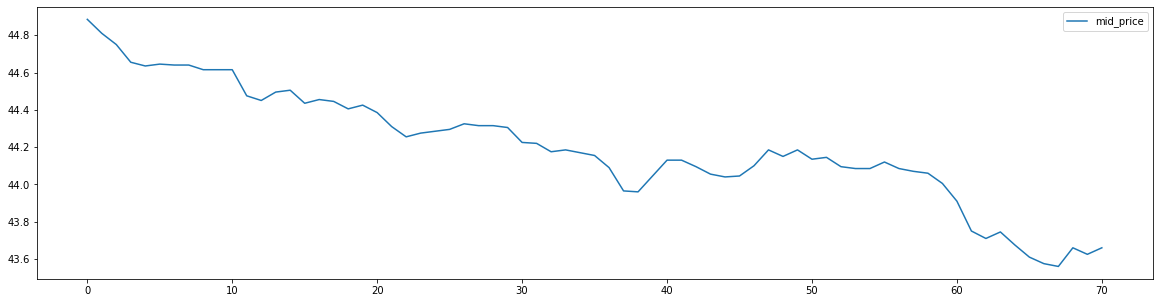

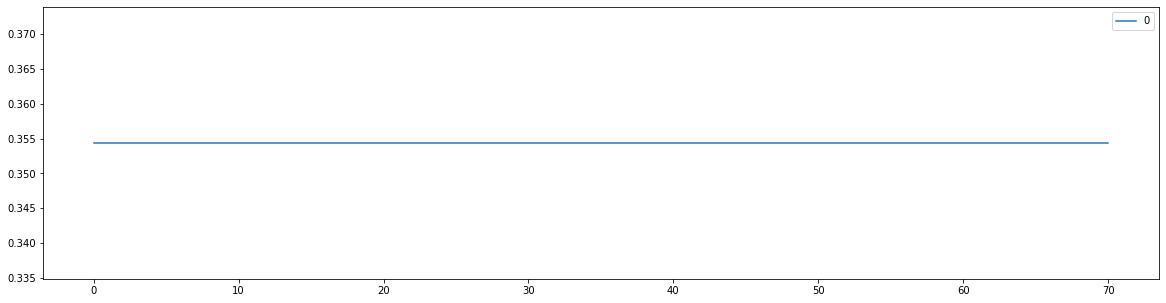

In [33]:
aaa = bst.predict(dvalidation)

df2 = pd.DataFrame(aaa)
df3 = pd.DataFrame(X_test['mid_price'])
df3.reset_index(inplace=True)

res = pd.concat([df2, df3], axis=1)
res.drop(['index'], axis=1,inplace=True)
df3.drop(['index'], axis=1,inplace=True)

df3.plot(figsize=(20,5))
df2.plot(figsize=(20,5))